In [23]:
import Pkg;

Pkg.add("Bloqade");
Pkg.add("PythonCall");
Pkg.add("KrylovKit");
Pkg.add("GenericTensorNetworks")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [1]:
using Bloqade
using PythonCall
using KrylovKit
using SparseArrays

plt = pyimport("matplotlib.pyplot");

In [2]:
Ω = 2π * 4
Δ_step = 30
Δ = LinRange(-2π * 10, 2π * 10, Δ_step);

In [3]:
total_time = 3.0;
Ω_max = 2π * 4;
Ω = piecewise_linear(clocks = [0.0, 0.1, 2.1, 2.2, total_time], values = [0.0, Ω_max, Ω_max, 0, 0]);

In [4]:
U1 = -2π * 10;
U2 = 2π * 10;
Δ = piecewise_linear(clocks = [0.0, 0.6, 2.1, total_time], values = [U1, U1, U2, U2]);

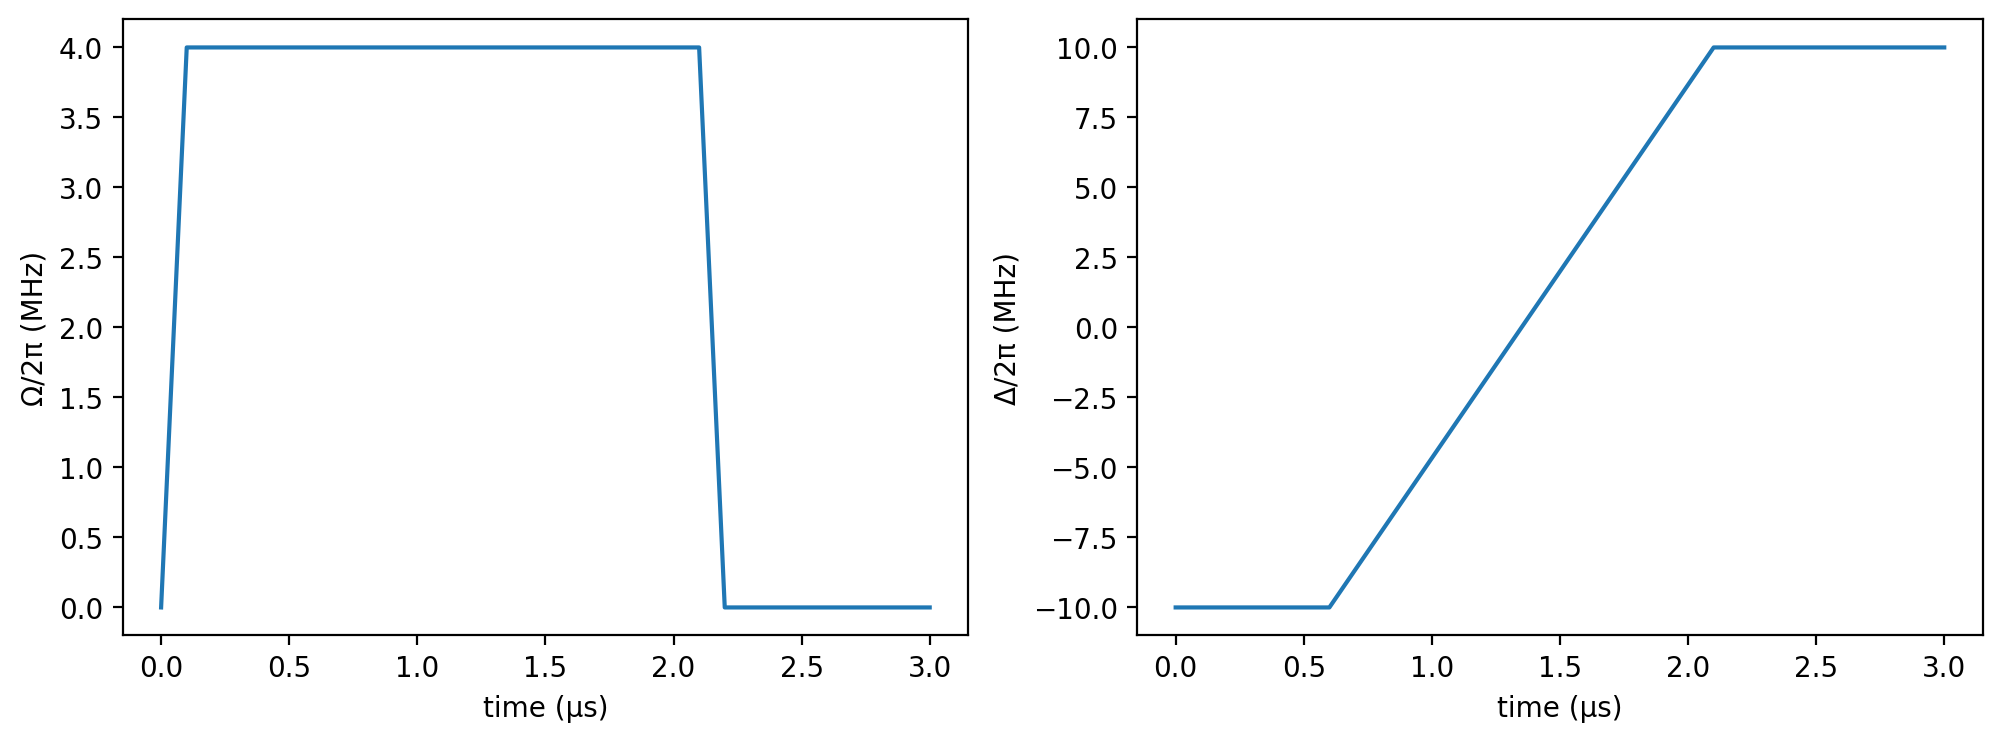

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

## Task2: Larger arrays with the Blockade Approximation

### What is the largest 1D array that you can simulate for the full Rydberg Hamiltonian, with exact time evolution as above? What implications does this have for quantum advantage, particularly in light of the experiments mentioned above?

The full Hilbert space increases exponentially ($d = 2^N$ for $N$ qubits), so that we cannot really simulate with exact time evolution for a large array. While the simulation finished in reasonable time up to 17 atoms, we checked that from 19 atoms the simulation goes on for quite a long time to finish. Please note that we mostly used odd number of sites for simplicity since an array with even number of sites has two degenerate ground states. It indicates that the quantum advantage is difficult to check with classical simulation since we cannot simulate the "answer" to check if our machine achieved quantum advantage.

In [24]:
nsites = 17
atoms = generate_sites(ChainLattice(), nsites, scale = 5.72);
h = rydberg_h(atoms; Δ, Ω);
reg = zero_state(nsites);
prob = SchrodingerProblem(reg, total_time, h);
integrator = init(prob, Vern8());

In [25]:
densities = []
for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
    push!(densities, rydberg_density(reg))
end
D = hcat(densities...);


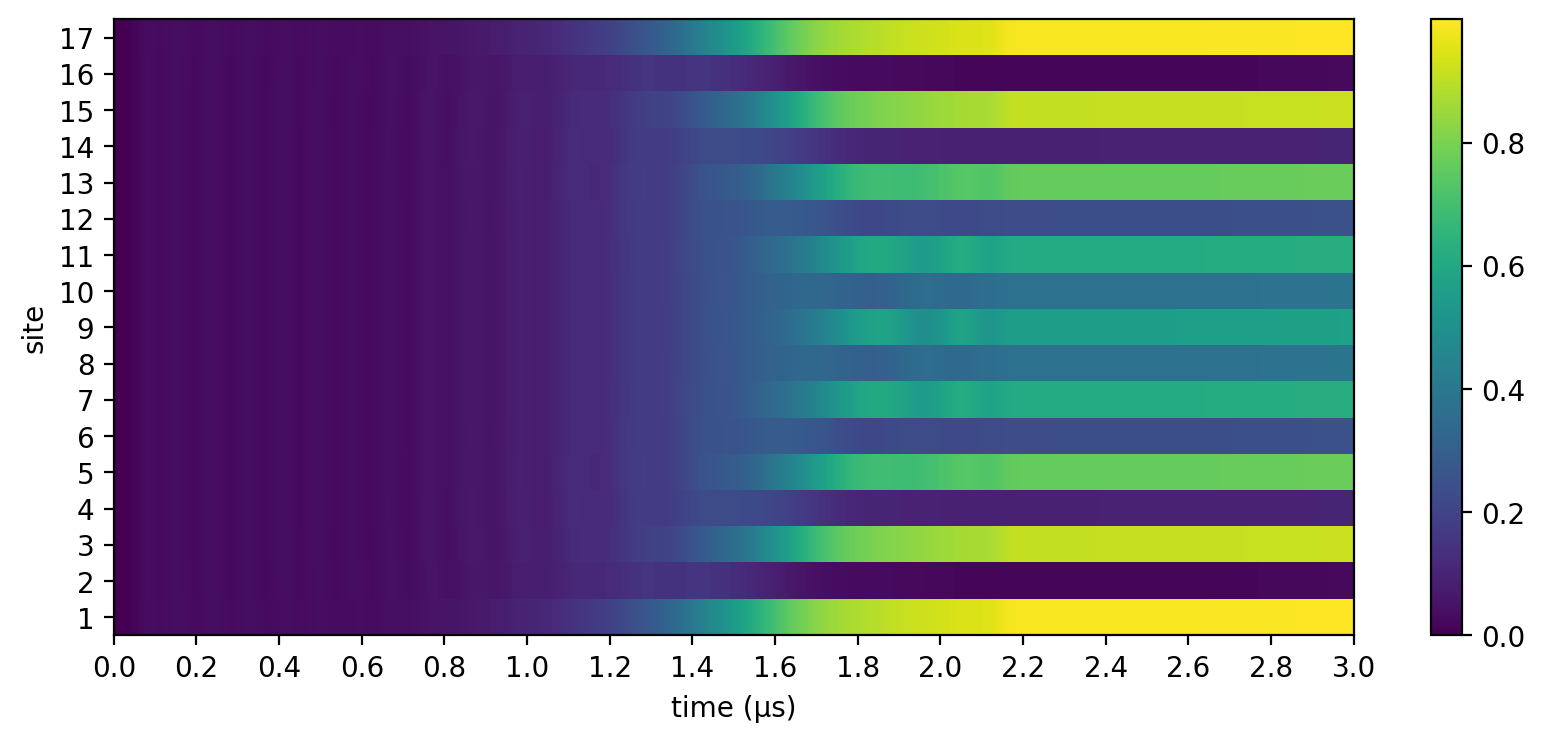

In [26]:
fig, ax = plt.subplots(figsize = (10, 4))
shw = ax.imshow(real(D), interpolation = "nearest", aspect = "auto", extent = [0, total_time, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:total_time)
ax.set_yticks(1:nsites)
bar = fig.colorbar(shw)
fig

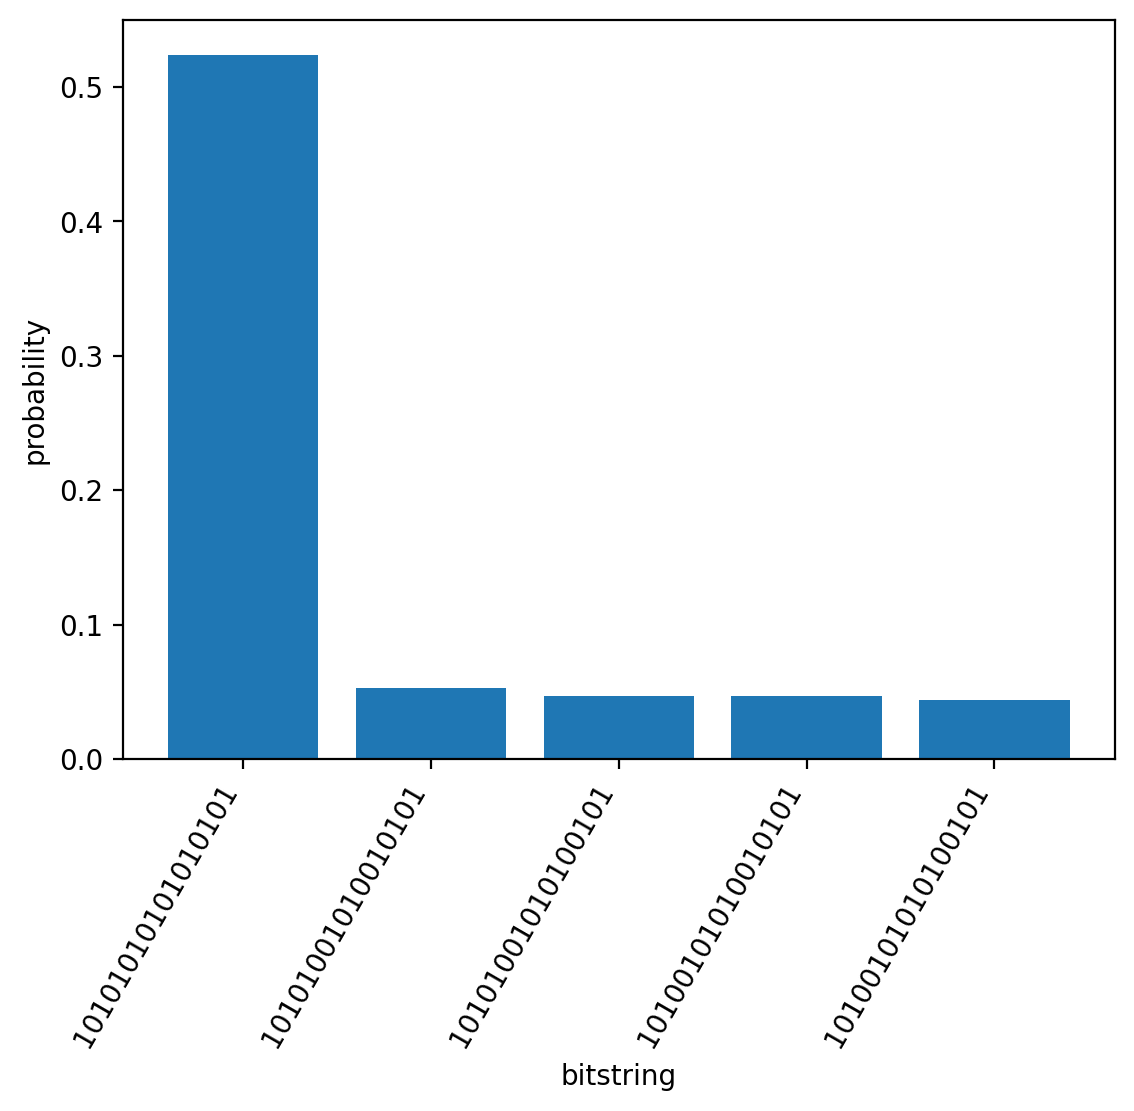

In [27]:
bitstring_hist(reg; nlargest = 5)

### Next, in order to significantly reduce the size of the state space required to solve Rydberg problems, one can eliminate states that violate the blockade constraint (e.g. more than one atom being excited within Rb). Implement the blockade approximation and justify it; i.e. when do you expect it to be valid? You can find more detailed explaination about this approximation in Rydberg Blockade section.

When van der Waals interaction is large enough for the atoms closer to the separation so that it costs too much energy to excite two atoms into Rydberg states at the same time, such configuration is essentially prohibited in the low energy dynamics up to certain order of perturbation. Therefore, we can truncate any subspace for which the atoms within that radius are both excited to Rydberg states.

### Repeat your study of 1D arrays, and find the largest system for which you can adiabatically prepare the Z2 state. 

One can increase the number larger than 17. We tested up to 25 atoms, which finished the simulation within ~10 min. However, the fidelity (probability of being in Z2 Rydberg lattice) seems to get worse. It is under 30% for 25 atoms, and even with 15 sites, probability of preparing Z2 state in 1D array is below 70%.

In [28]:
nsites = 25
atoms = generate_sites(ChainLattice(), nsites, scale = 5.72);

space = blockade_subspace(atoms, 5.73);
h = rydberg_h(atoms; Δ, Ω);

reg = zero_state(space);
prob = SchrodingerProblem(reg, total_time, h);
integrator = init(prob, Vern8());

densities = []
for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
    push!(densities, rydberg_density(reg))
end
D = hcat(densities...);

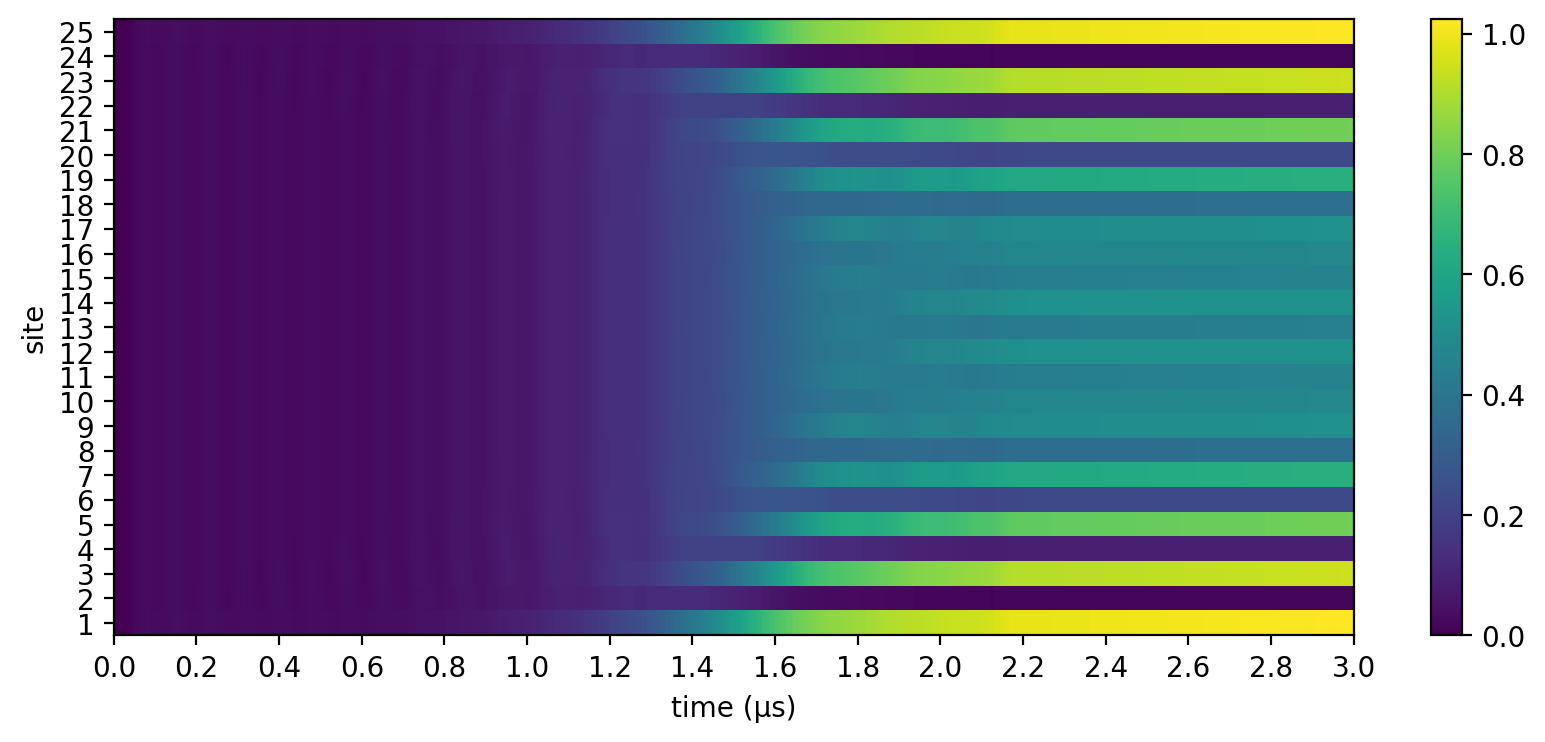

In [29]:
fig, ax = plt.subplots(figsize = (10, 4))
shw = ax.imshow(real(D), interpolation = "nearest", aspect = "auto", extent = [0, total_time, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:total_time)
ax.set_yticks(1:nsites)
bar = fig.colorbar(shw)
fig

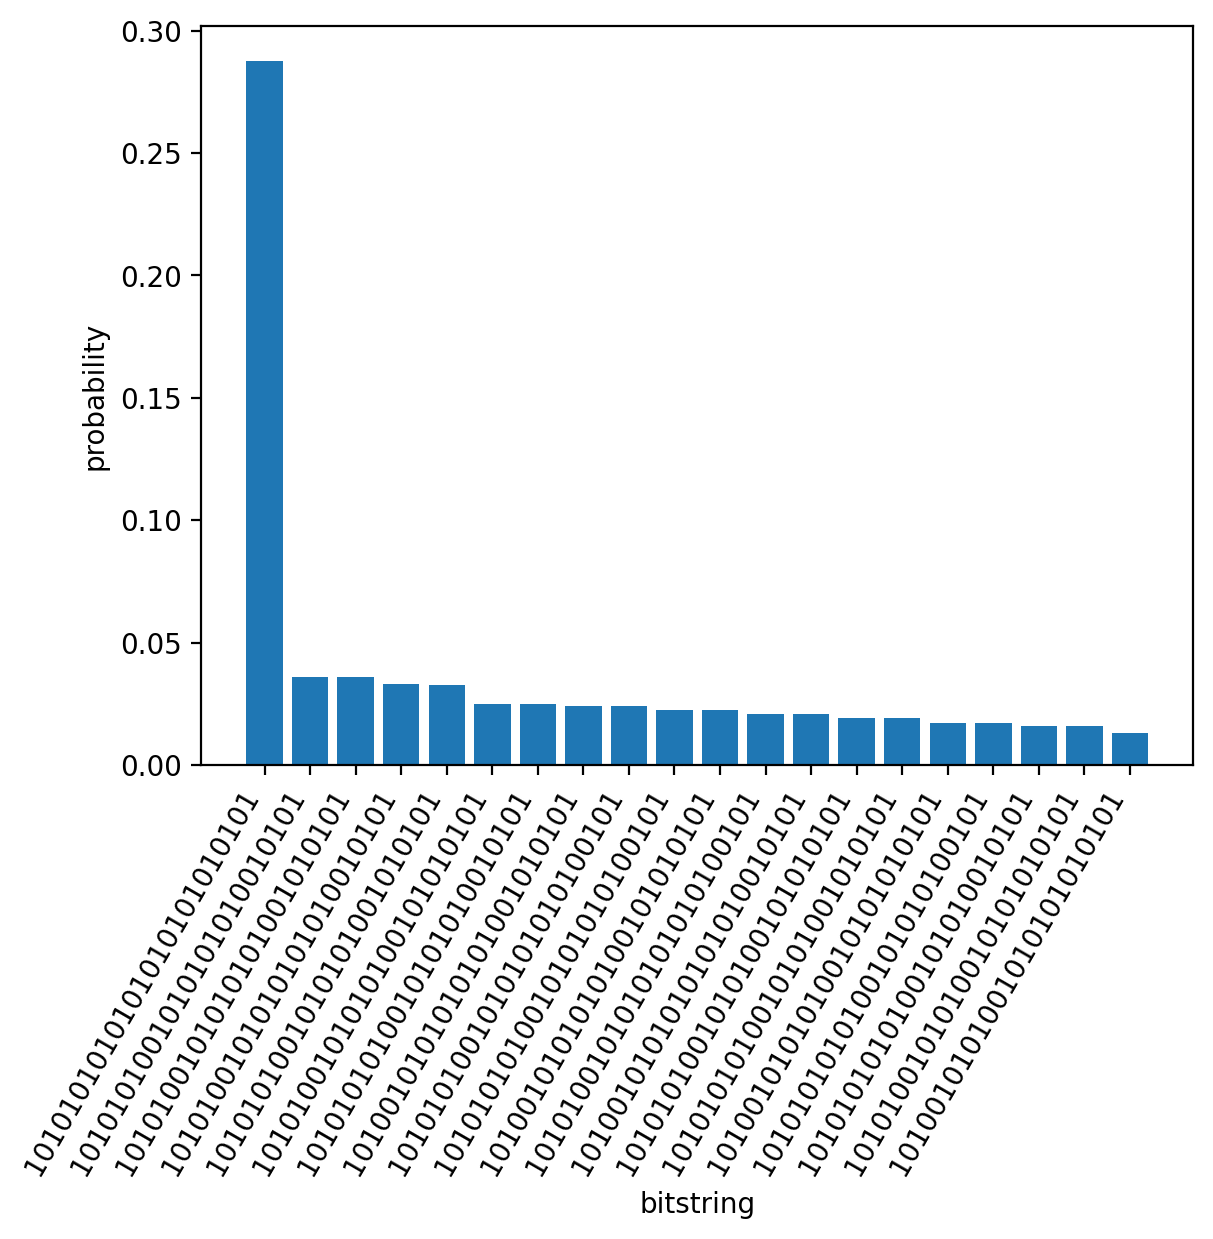

In [30]:
bitstring_hist(reg; nlargest = 20)

### What is the largest 2D array for which you can adiabatically prepare the checkerboard phase?

Let's try 2D array below. Again, we used odd number of sites for simplicity. Again, roughly 25 atoms (5x5) lattice is roughly at the edge of the computational limit of a laptop. For instance, the simulation does not finish for 5x7 lattice.

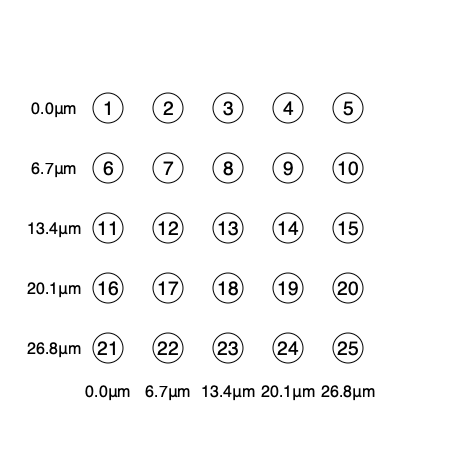

In [31]:
nx, ny = 5, 5
nsites = nx * ny
lattice = 6.7
atoms = generate_sites(SquareLattice(), nx, ny, scale = lattice)

In [32]:
total_time = 2.9
Ω_max = 2π * 4.3
Ω = piecewise_linear(clocks = [0.0, 0.3, 2.6, total_time], values = [0.0, Ω_max, Ω_max, 0]);

U = 2π * 15.0
Δ = piecewise_linear(clocks = [0.0, 0.3, 2.6, total_time], values = [-U, -U, U, U]);

In [33]:
h = rydberg_h(atoms; Δ, Ω)
space = blockade_subspace(atoms, lattice);
reg = zero_state(space);

prob = SchrodingerProblem(reg, total_time, h);
integrator = init(prob, Vern8());

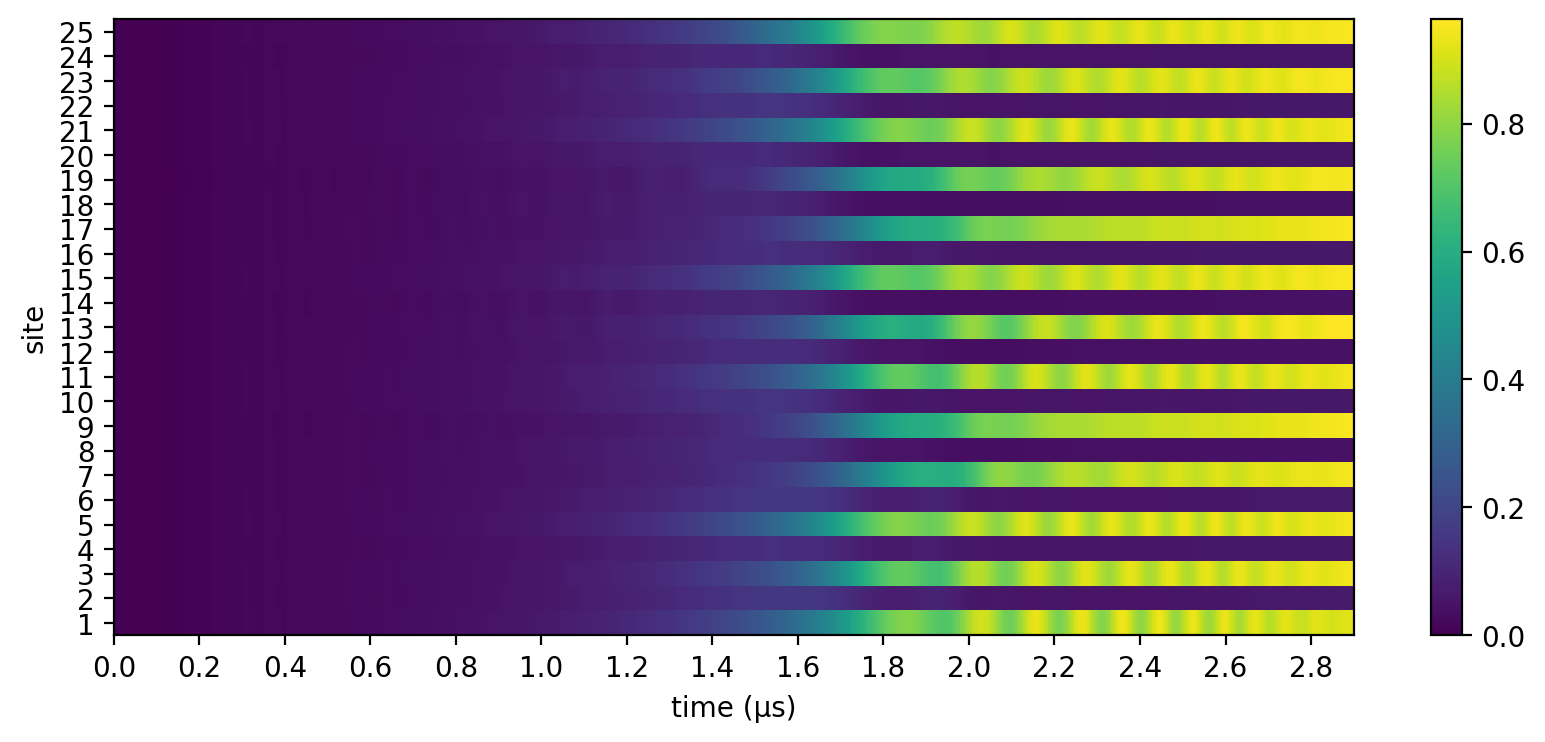

In [34]:
densities = [];
for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
    push!(densities, rydberg_density(reg))
end
D = hcat(densities...)

fig, ax = plt.subplots(figsize = (10, 4))
shw = ax.imshow(real(D), interpolation = "nearest", aspect = "auto", extent = [0, total_time, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:total_time)
ax.set_yticks(1:nsites)
bar = fig.colorbar(shw)
fig

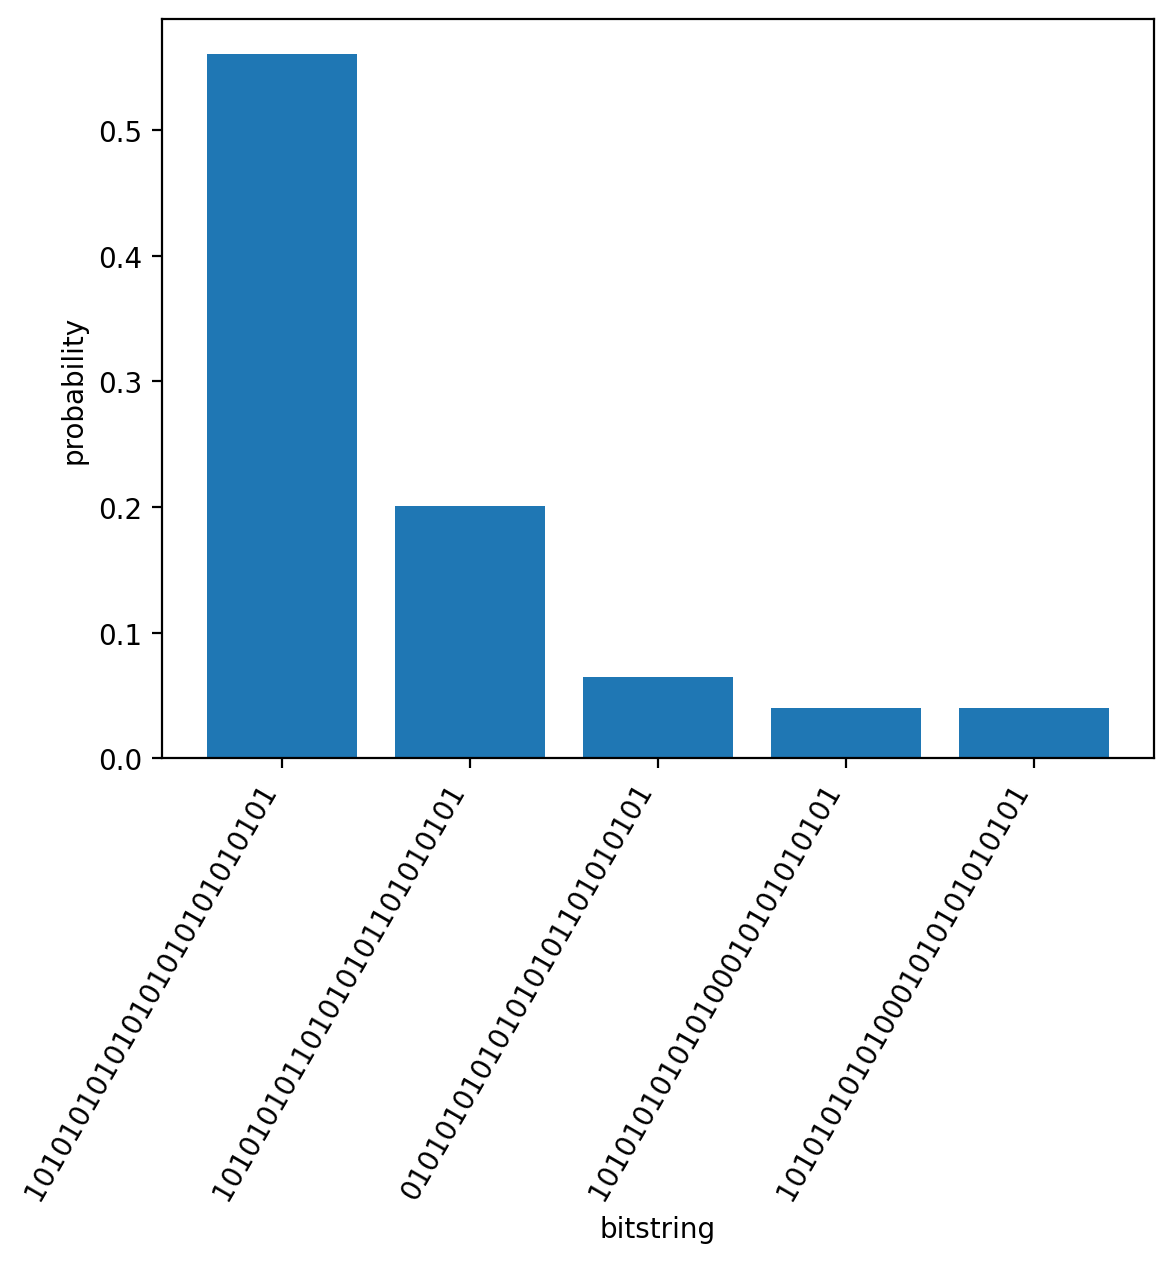

In [35]:
nx, ny = 3, 9
nsites = nx * ny
lattice = 6.7
atoms = generate_sites(SquareLattice(), nx, ny, scale = lattice)
h = rydberg_h(atoms; Δ, Ω)
space = blockade_subspace(atoms, lattice);
reg = zero_state(space);

prob = SchrodingerProblem(reg, total_time, h)
emulate!(prob)
bitstring_hist(prob.reg; nlargest = 5)

### Has quantum advantage for 2D arrays already been achieved?

While it could be controversial statement, we have seen advantage of using quantum simulator in contrast to conventional computation. The Science paper from Lukin group demonstrated that their quantum simulator can simulate 17x17 size lattice successfully, which seems not possible to simulate classically on the computer.

## QAOA

In [8]:
using Random
using GenericTensorNetworks

Random.seed!(2)
atoms = generate_sites(SquareLattice(), 4, 4; scale = 4.5) |> random_dropout(0.2)
Bloqade.plot(atoms, blockade_radius = 7.5)

graph = BloqadeMIS.unit_disk_graph(atoms, 7.5)
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graph), CountingMax())[]

(4.0, 26.0)ₜ

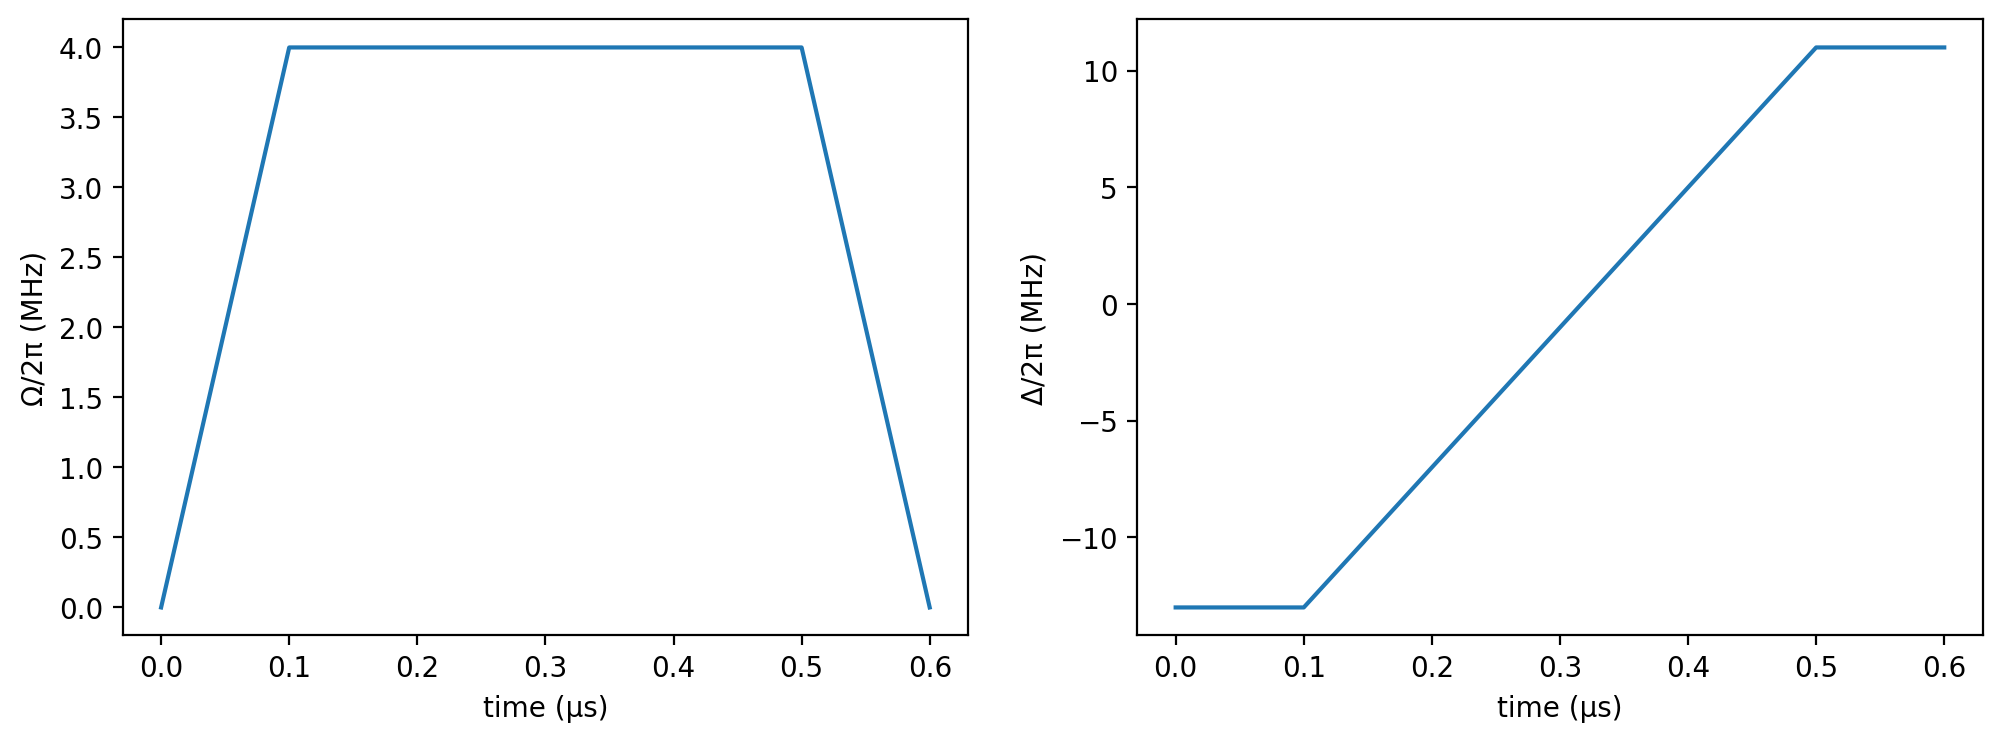

In [9]:
T_max = 0.6
Ω_max = 2π * 4
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -2π * 13
Δ_end = 2π * 11
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

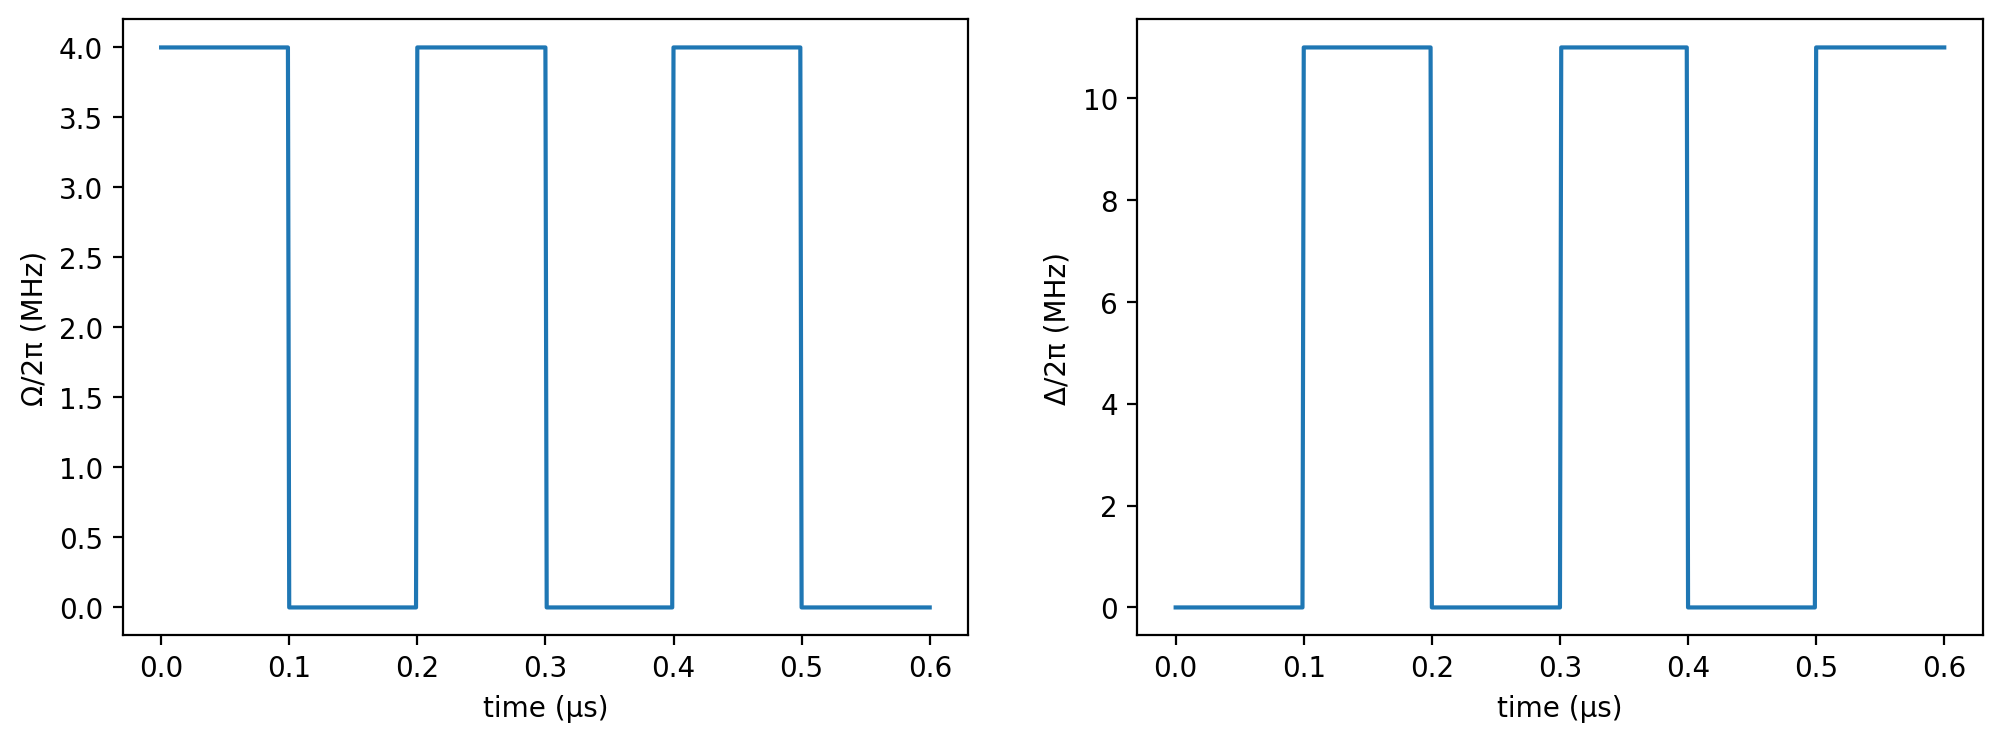

In [10]:
durations = fill(0.1, 6)
clocks = [0, cumsum(durations)...]
Ω2 = piecewise_constant(; clocks = clocks, values = repeat([Ω_max, 0.0], 3))
Δ2 = piecewise_constant(; clocks = clocks, values = repeat([0.0, Δ_end], 3))

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω2)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ2)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [11]:
hamiltonian2 = rydberg_h(atoms; Ω = Ω2, Δ = Δ2)
nsites = length(atoms)
subspace = blockade_subspace(atoms, 7.5)  # we run our simulation within the blockade subspace
prob2 = KrylovEvolution(zero_state(subspace), clocks, hamiltonian2)
emulate!(prob2);

In [12]:
loss_MIS(reg) = -rydberg_density_sum(prob2.reg)
loss_MIS(prob2.reg)

-2.5628869128026803

In [13]:
function loss_piecewise_constant(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) % 2 == 0
    Ω_max = 4 * 2π
    Δ_end = 11 * 2π
    p = length(x) ÷ 2

    # detuning and rabi terms
    durations = abs.(x)   # the durations of each layer of the QAOA pulse take the optimizing vector x as their input
    clocks = [0, cumsum(durations)...]
    Ωs = piecewise_constant(; clocks = clocks, values = repeat(T[Ω_max, 0.0], p))
    Δs = piecewise_constant(; clocks = clocks, values = repeat(T[0.0, Δ_end], p))

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, 7.5)  # we run our simulation within the blockade subspace
    prob = KrylovEvolution(zero_state(Complex{T}, subspace), clocks, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg
end

loss_piecewise_constant (generic function with 1 method)

In [14]:
x0 = durations
rydberg_density, reg1 = loss_piecewise_constant(atoms, x0)
rydberg_density

-2.5628869128026803

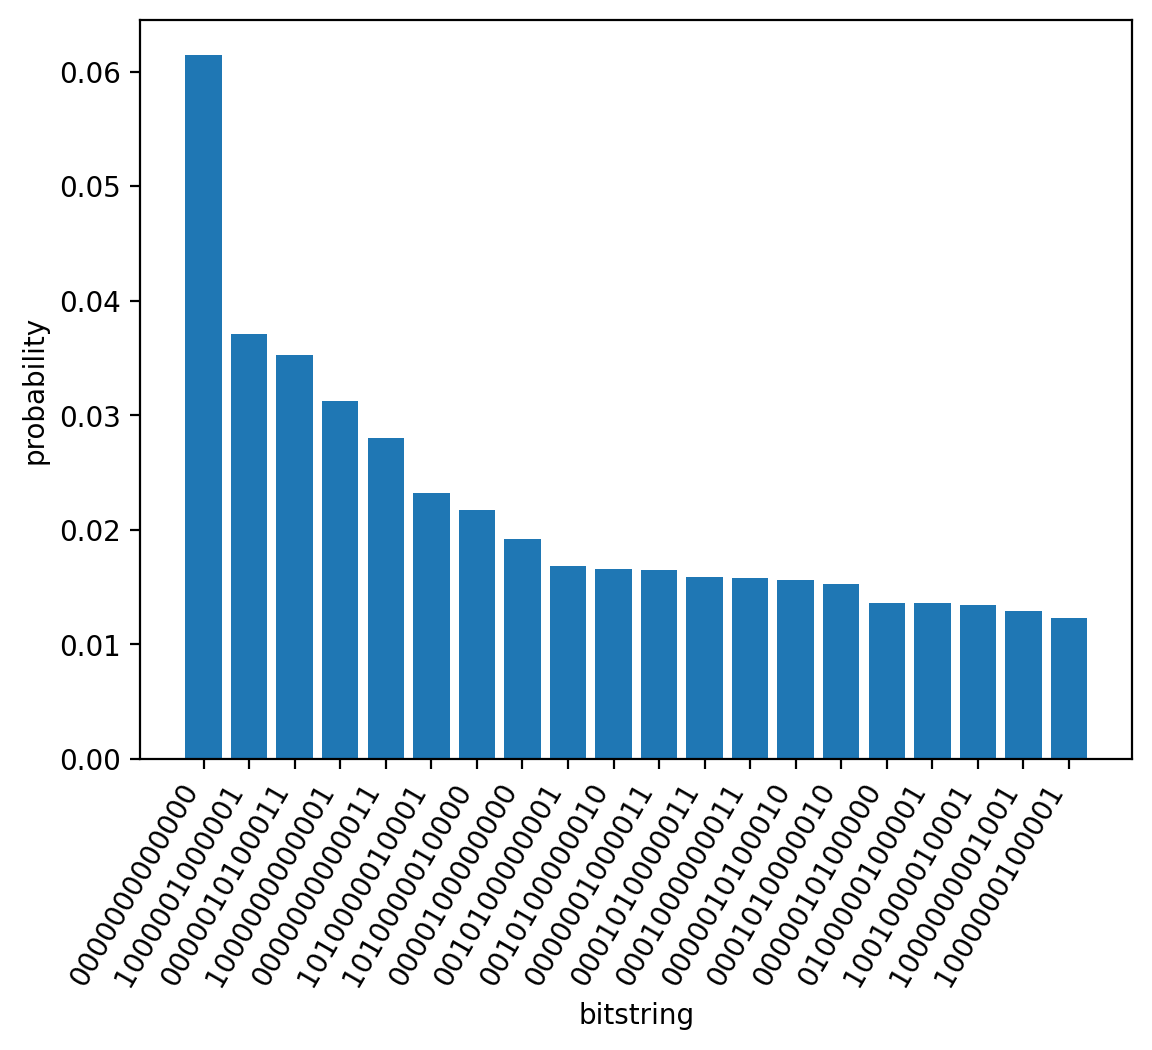

In [15]:
bitstring_hist(reg1; nlargest = 20)

In [18]:
Pkg.add("Optim")

using Optim

optresult = Optim.optimize(x -> loss_piecewise_constant(atoms, x)[1], x0)

rydberg_density_final, reg1_final = loss_piecewise_constant(atoms, optresult.minimizer)
rydberg_density_final

   Resolving package versions...
   Installed PositiveFactorizations ─ v0.2.4
   Installed Optim ────────────────── v1.7.0
    Updating `~/.julia/environments/v1.7/Project.toml`
  [429524aa] + Optim v1.7.0
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [429524aa] + Optim v1.7.0
  [85a6dd25] + PositiveFactorizations v0.2.4
Precompiling project...
  ✓ PositiveFactorizations
  ✓ Optim
  2 dependencies successfully precompiled in 3 seconds (282 already precompiled)


-3.09659102600122

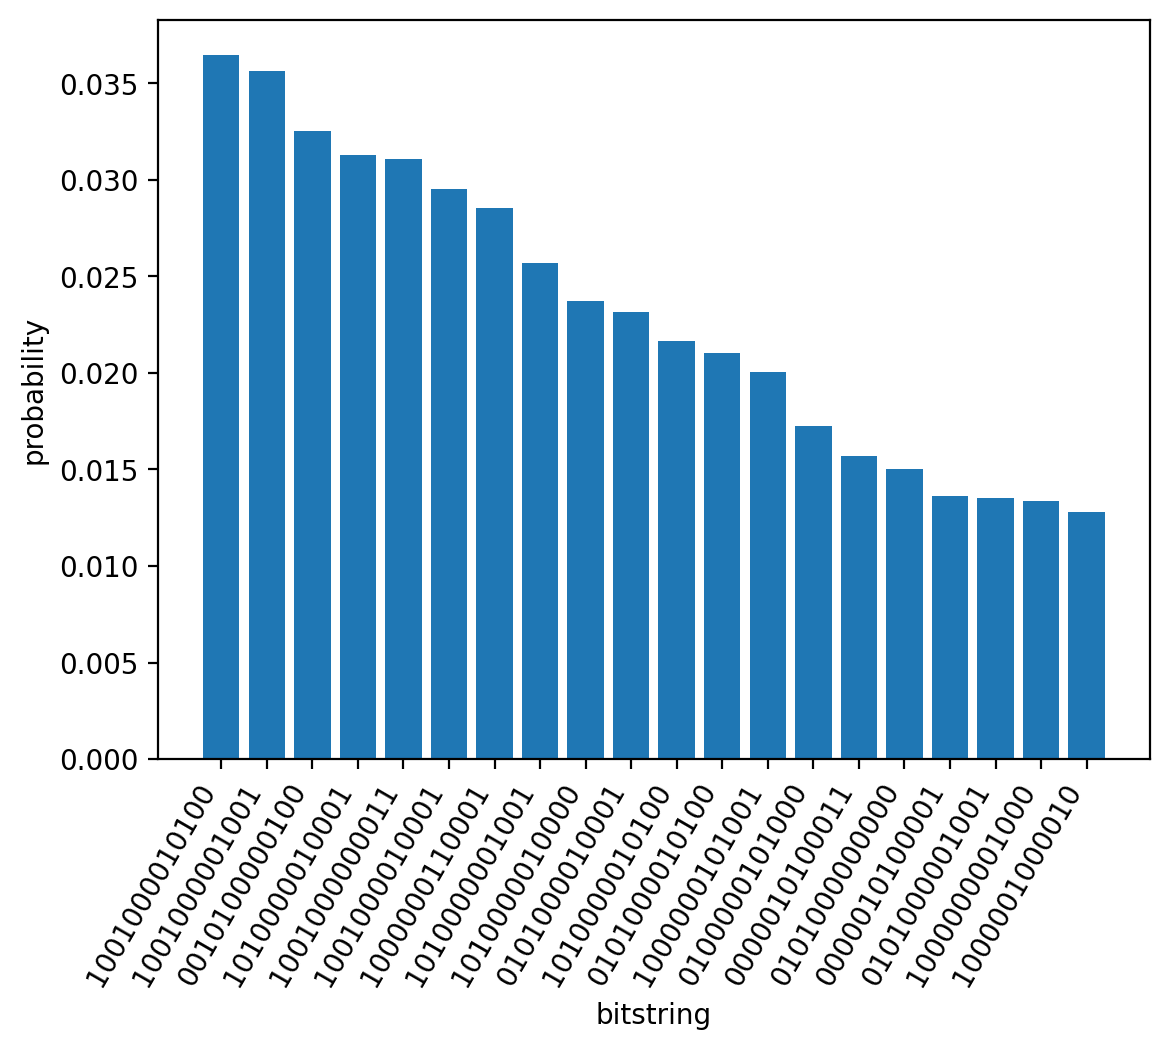

In [19]:
bitstring_hist(reg1_final; nlargest = 20)

In [21]:
best_bit_strings = most_probable(reg1_final, 2)
all_optimal_configs = GenericTensorNetworks.solve(IndependentSet(graph), ConfigsMax())[]
@assert all(bs -> GenericTensorNetworks.StaticBitVector([bs...]) ∈ all_optimal_configs.c, best_bit_strings)

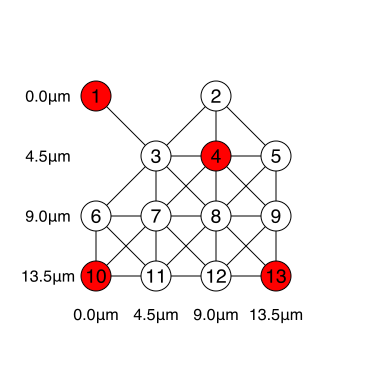

In [22]:
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])